<a href="https://colab.research.google.com/github/llayer/StromboliWF/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df = pd.read_hdf('/content/gdrive/My Drive/signal_norm.h5')

In [0]:
def exclude_days(df, days):
    
    for day in days:
        mask = ((df['time'] < day[0]) | (df['time'] > day[1]))
        df = df.loc[mask]
    return df

In [0]:
# Exclude the eruption days
eruption_days = [ ('2019-07-03', '2019-07-04'), ('2019-08-28', '2019-08-29'), ('2019-08-29', '2019-08-30')]
df = exclude_days(df, eruption_days)

In [7]:
len(df)

19757

In [0]:
df = df.dropna()

In [9]:
len(df)

19748

In [0]:
features = df.drop(['time'], axis=1)

In [0]:
features = features.values

In [12]:
features.shape

(19748, 1550)

In [13]:
np.isnan(features).any()

False

## 1. Dense auto encoder

In [14]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.optimizers import Adam, SGD
from keras.utils import plot_model


Using TensorFlow backend.


In [0]:
def train_dense(features, encoding_dim):

    input_img= Input(shape=(features.shape[1],))
    encoded = Dense(units=500, activation='relu')(input_img)
    #encoded = Dense(units=200, activation='relu')(encoded)
    encoded = Dense(units=encoding_dim, activation='relu')(encoded)
    decoded = Dense(units=500, activation='relu')(encoded)
    #decoded = Dense(units=500, activation='relu')(decoded)
    decoded = Dense(units=features.shape[1])(decoded)

    # Building autoencoder
    autoencoder=Model(input_img, decoded)
    #extracting encoder
    encoder = Model(input_img, encoded)
    # compiling the autoencoder
    ADAM = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=100)
    autoencoder.compile(optimizer=ADAM, loss='mean_squared_error', metrics=['accuracy'])
    
    #plot_model(autoencoder, show_shapes=True, show_layer_names=False)
    
    history = autoencoder.fit(features, features, epochs=100, batch_size = 32, validation_split=0.2, verbose=1)  

    return history, autoencoder, encoder

In [0]:
history_100, autoencoder_100, encoder_100 = train_dense(features, 100)
#history_200, autoencoder_200, encoder_200 = train_dense(features, 200)
#history_300, autoencoder_300, encoder_300 = train_dense(features, 300)
#history_400, autoencoder_400, encoder_400 = train_dense(features, 400)
history_500, autoencoder_500, encoder_500 = train_dense(features, 500)

Train on 15798 samples, validate on 3950 samples
Epoch 1/100
15798/15798 [==============================] - 6s 357us/step - loss: 0.8501 - acc: 0.0207 - val_loss: 0.7725 - val_acc: 0.0309
Epoch 2/100
15798/15798 [==============================] - 3s 218us/step - loss: 0.6400 - acc: 0.0654 - val_loss: 0.6537 - val_acc: 0.0694
Epoch 3/100
15798/15798 [==============================] - 3s 219us/step - loss: 0.5552 - acc: 0.0984 - val_loss: 0.6007 - val_acc: 0.0916
Epoch 4/100
15798/15798 [==============================] - 3s 217us/step - loss: 0.5124 - acc: 0.1251 - val_loss: 0.5689 - val_acc: 0.1089
Epoch 5/100
15798/15798 [==============================] - 3s 216us/step - loss: 0.4855 - acc: 0.1434 - val_loss: 0.5474 - val_acc: 0.1187
Epoch 6/100
15798/15798 [==============================] - 3s 215us/step - loss: 0.4682 - acc: 0.1566 - val_loss: 0.5342 - val_acc: 0.1286
Epoch 7/100
15798/15798 [==============================] - 3s 216us/step - loss: 0.4567 - acc: 0.1676 - val_loss: 0.5

In [0]:
def predict(encoder, autoencoder, name = 'dense', store=True):

    preds_encode = encoder.predict(features)
    preds_auto = autoencoder.predict(features)

    if store == True:
        dim = preds_encode.shape[1]
        preds_df = pd.DataFrame(preds_encode)
        preds_df['time'] = df['time']
        print(preds_df.shape)
        print(name +'_' + str(dim) + '.h5')
        preds_df.to_hdf('/content/gdrive/My Drive/' + name +'_' + str(dim) + '.h5', 'frame', store= 'tables')
    
    return preds_encode, preds_auto

In [0]:
preds_encode, preds_auto = predict(encoder_500, autoencoder_500)

(19748, 501)
dense_500.h5


/usr/local/lib/python3.6/dist-packages/pandas/io/pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['time']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


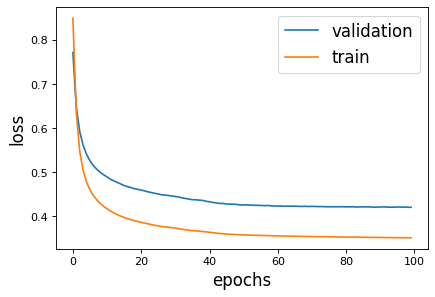

In [0]:
plt.figure(figsize=(6,4), dpi=80)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.ylabel('loss', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(['validation', 'train'], loc='upper right', prop={'size': 15})

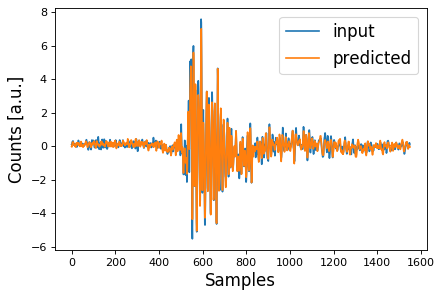

In [0]:
import matplotlib.pyplot as plt
ifeat = 4

plt.figure(figsize=(6,4), dpi=80)
plt.plot(features[ifeat], alpha = 1)
plt.plot(preds_auto[ifeat], alpha=1)
plt.ylabel('Counts [a.u.]', fontsize=15)
plt.xlabel('Samples', fontsize=15)
plt.legend(['input', 'predicted'], loc='upper right', prop={'size': 15})

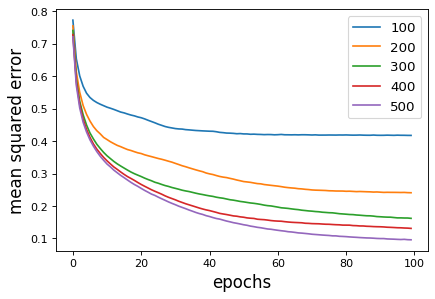

In [0]:
plt.figure(figsize=(6,4), dpi=80)
plt.plot(history_100.history['val_loss'])
plt.plot(history_200.history['val_loss'])
plt.plot(history_300.history['val_loss'])
plt.plot(history_400.history['val_loss'])
plt.plot(history_500.history['val_loss'])
plt.ylabel('mean squared error', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(['100', '200', '300', '400', '500'], loc='upper right', prop={'size': 12})

## 2. LSTM autoencoder

In [0]:
features = features.reshape((features.shape[0], 31, 50))
features = features.reshape(features.shape[0] * 31, features.shape[2], 1)

In [16]:
features.shape

(612188, 50, 1)

In [0]:
def predict(encoder, auto, store = True):
    p_encode = encoder.predict(features)
    p_auto = auto.predict(features)

    n_samp = p_encode.shape[0] / 31
    p_encode = p_encode.reshape(int(n_samp), 31 * p_encode.shape[1])
    p_auto = p_auto.reshape(int(n_samp), 31 * p_auto.shape[1])
    
    if store == True:
        dim = p_encode.shape[1]
        preds_df = pd.DataFrame(p_encode)
        preds_df['time'] = df['time']
        print(preds_df.shape)
        print('lstm_' + str(dim) + '.h5')
        preds_df.to_hdf('/content/gdrive/My Drive/' + 'lstm_' + str(dim) + '.h5', 'frame', store= 'tables')

    return p_encode, p_auto

In [0]:
def train_lstm(features, encoding_dim):

    # 16 worked with tanh and the defined ADAM
    # define model
    model = Sequential()
    #model.add(LSTM(10, activation='tanh', input_shape=(features.shape[1],1)))
    model.add(CuDNNLSTM(encoding_dim, input_shape=(features.shape[1],1)))
    model.add(RepeatVector(features.shape[1]))
    #model.add(LSTM(10, activation='tanh', return_sequences=True))
    model.add(CuDNNLSTM(encoding_dim, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True,clipnorm=100)
    ADAM = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=100)
    model.compile(optimizer=ADAM, loss='mse' )#binary_crossentropy') # loss='mse')
    
    #plot_model(model, show_shapes=True, show_layer_names=False)

    #history = model.fit(features, features, epochs=20, batch_size = 32, validation_split=0.2, verbose=1)  
    history = model.fit(features, features, epochs=20, batch_size = 32, validation_split=0.2, verbose=1)  

    lstm_encoder = Model(inputs=model.inputs, outputs=model.layers[0].output)

    return history, model, lstm_encoder

In [22]:
history_10, auto_10, encoder_10 = train_lstm(features, 10)
predict(encoder_10, auto_10)
#history_15, auto_15, encoder_15 = train_lstm(features, 15)
#predict(encoder_15, auto_15)
#history_8, auto_8, encoder_8 = train_lstm(features, 8)
#predict(encoder_8, auto_8)
#history_12, auto_12, encoder_12 = train_lstm(features, 12)
#predict(encoder_12, auto_12)
loss = pd.DataFrame(history_10.history['val_loss'])
loss.to_hdf('/content/gdrive/My Drive/' + 'hist_lstm_10' + '.h5', 'frame', store= 'tables')

Train on 489750 samples, validate on 122438 samples
Epoch 1/20
489750/489750 [==============================] - 154s 314us/step - loss: 0.5023 - val_loss: 0.3690
Epoch 2/20
489750/489750 [==============================] - 154s 314us/step - loss: 0.3304 - val_loss: 0.3014
Epoch 3/20
489750/489750 [==============================] - 151s 308us/step - loss: 0.2861 - val_loss: 0.2695
Epoch 4/20
489750/489750 [==============================] - 148s 302us/step - loss: 0.2602 - val_loss: 0.2405
Epoch 5/20
489750/489750 [==============================] - 145s 296us/step - loss: 0.2439 - val_loss: 0.2132
Epoch 6/20
489750/489750 [==============================] - 145s 296us/step - loss: 0.2225 - val_loss: 0.2079
Epoch 7/20
489750/489750 [==============================] - 150s 307us/step - loss: 0.2148 - val_loss: 0.2084
Epoch 8/20
489750/489750 [==============================] - 149s 304us/step - loss: 0.2104 - val_loss: 0.1996
Epoch 9/20
489750/489750 [==============================] - 144s 294

/usr/local/lib/python3.6/dist-packages/pandas/io/pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['time']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


"\nplt.figure(figsize=(6,4), dpi=80)\nplt.plot(history_8.history['val_loss'])\nplt.plot(history_10.history['val_loss'])\nplt.plot(history_12.history['val_loss'])\nplt.plot(history_15.history['val_loss'])\nplt.ylabel('mean squared error', fontsize=15)\nplt.xlabel('epochs', fontsize=15)\nplt.legend(['8', '10', '12', '15'], loc='upper right', prop={'size': 12})\n"

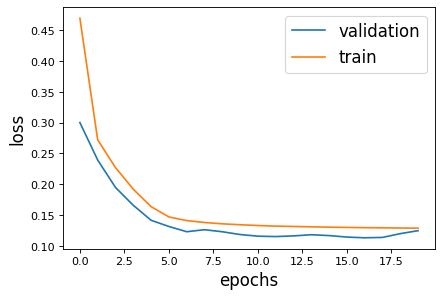

In [21]:
plt.figure(figsize=(6,4), dpi=80)
plt.plot(history_12.history['val_loss'])
plt.plot(history_12.history['loss'])
plt.ylabel('loss', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(['validation', 'train'], loc='upper right', prop={'size': 15})

In [0]:
preds_auto.shape

(612188, 50, 1)

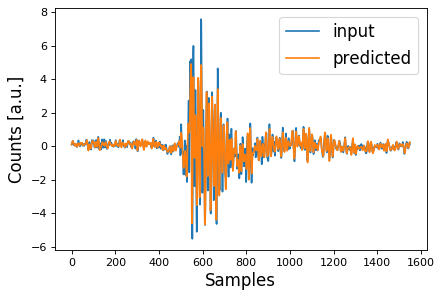

In [0]:
import matplotlib.pyplot as plt
ifeat = 4

n_samp = int( features.shape[0] / (31) )
#features = features.reshape((n_samp, 31 * 50))

plt.figure(figsize=(6,4), dpi=80)
plt.plot(features[ifeat], alpha = 1)
plt.plot(p_auto[ifeat], alpha=1)
plt.ylabel('Counts [a.u.]', fontsize=15)
plt.xlabel('Samples', fontsize=15)
plt.legend(['input', 'predicted'], loc='upper right', prop={'size': 15})

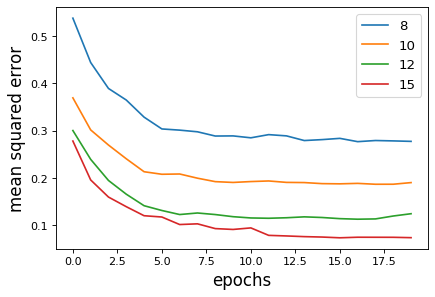

In [30]:
path = '/content/gdrive/My Drive/' 
history_8 = pd.read_hdf(path + 'hist_lstm_8.h5')
history_10 = pd.read_hdf(path + 'hist_lstm_10.h5')
history_12 = pd.read_hdf(path + 'hist_lstm_12.h5')
history_15 = pd.read_hdf(path + 'hist_lstm_15.h5')

plt.figure(figsize=(6,4), dpi=80)
plt.plot(history_8)
plt.plot(history_10)
plt.plot(history_12)
plt.plot(history_15)
plt.ylabel('mean squared error', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(['8', '10', '12', '15'], loc='upper right', prop={'size': 12})

In [0]:
import matplotlib.pyplot as plt
ifeat = 4

yhat = model.predict(features[0:31], verbose=1)
sig = features[0:31]

plt.figure(figsize=(6,4), dpi=80)
plt.plot(features[ifeat], alpha = 1)
plt.plot(preds_auto[ifeat], alpha=1)
plt.ylabel('Counts [a.u.]', fontsize=15)
plt.xlabel('Samples', fontsize=15)
plt.legend(['input', 'predicted'], loc='upper right', prop={'size': 15})

In [0]:
yhat = model.predict(features[0:31], verbose=1)
sig = features[0:31]

31/31 [==============================] - 0s 300us/step


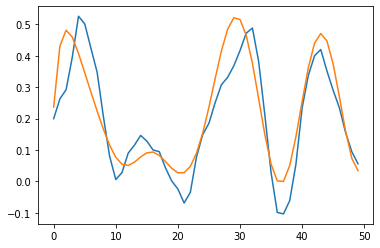

In [0]:
import matplotlib.pyplot as plt
ifeat = 7
#for f, pred in zip(features[ifeat], yhat[ifeat]):
#    print(f, pred)

plt.plot(features[ifeat])
plt.plot(yhat[ifeat])


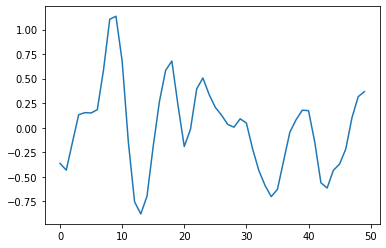

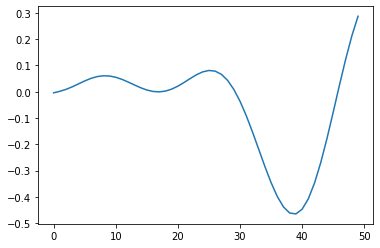

In [0]:
sig = sig.reshape(31 * 50)

In [0]:
yhat = yhat.reshape(31 * 50)

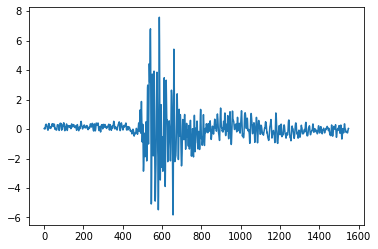

In [0]:
plt.plot(sig)

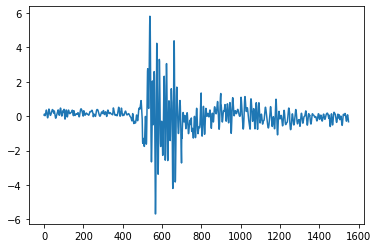

In [0]:
plt.plot(yhat)